# Installation

In [2]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-11-28 14:22:21--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  43.3MB/s    in 62s     

2021-11-28 14:23:23 (42.4 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [3]:
%%bash
pip install googledrivedownloader
pip install wandb
pip install pandas

# Imports

In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload 2

from tts.collate_fn import Batch, LJSpeechCollator
from tts.collate_fn.collate import TestCollator
from tts.datasets.ljspeech import LJSpeechDataset
from tts.datasets.text import TextDataset
from tts.melspec import MelSpectrogram, MelSpectrogramConfig
from tts.model import Vocoder, GraphemeAligner
from tts.model.fastspeech import FastSpeech
from tts.model.config import FSConfig
from tts.trainer.simple_trainer import train_epoch, evaluate
from tts.loss.fast_speech import FastSpeechLossWrapper
from tts.logger.wandb import WanDBWriter
from tts.utils.util import set_random_seed

set_random_seed(42)

device = 'cuda:0'

In [20]:
from itertools import islice, repeat
from torch.utils.data import DataLoader
import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
from IPython import display
import wandb
import torch
from torch import nn
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

In [21]:
dataset = LJSpeechDataset('.')
val_dataset = TextDataset()
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)

dataloader = DataLoader(dataset, num_workers=4, batch_size=32, shuffle=True, collate_fn=LJSpeechCollator())
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=TestCollator())

# Aligner

In [35]:
train_config = {
    'use_wandb': True,
    'grad_accum_steps': 1,
    'len_epoch': 100_000,
    'device': device,
    'overfit_batch': True,
    'wandb_project': 'FastSpeech',
    'log_train_step': 300,
    'n_epochs': 10
}

In [25]:
writer = WanDBWriter(train_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [32]:
aligner = GraphemeAligner().to(device)

config = FSConfig(hidden_size=384, encoder_num_heads=6, encoder_num_layers=6, dropout_p=0)
model = FastSpeech(config)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, **{
    "steps_per_epoch": len(dataloader),
    "epochs": train_config['n_epochs'],
    "anneal_strategy": "cos",
    "max_lr": 2e-3,
    "pct_start": 0.1
})

loss = FastSpeechLossWrapper()
vocoder = Vocoder().to(device).eval()

In [9]:
model.load_state_dict(torch.load('model_epoch=260')['model'])

<All keys matched successfully>

In [30]:
for module_name, module in model.named_modules():
    if module_name.endswith('drop'):
        module.p = 0.1

In [33]:
import numpy as np
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [34]:
count_parameters(model)

52752721

In [36]:
if train_config['overfit_batch']:
    dataloader = iter(dataloader)
    batch = next(dataloader)
    dataloader = repeat(batch)

In [16]:
writer.set_step(142_887)

In [ ]:
for i in range(260, 260 + train_config['n_epochs']):
    train_epoch(model, optimizer, dataloader, scheduler, loss, train_config, featurizer, aligner, writer, vocoder=vocoder)
    
    evaluate(model, val_loader, train_config, vocoder, writer)
    
    if i % 10 == 0:
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, f"model_epoch={i}")

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

In [37]:
for i in range(train_config['n_epochs']):
    train_epoch(model, optimizer, dataloader, scheduler, loss, train_config, featurizer, aligner, writer, vocoder=vocoder)
    
    evaluate(model, val_loader, train_config, vocoder, writer)
    
    if i % 10 == 0:
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, f"model_epoch={i}")

0it [00:00, ?it/s]

ValueError: Tried to step 4102 times. The specified number of total steps is 4100

# Eval

In [ ]:
torch

In [112]:
torch.save(model.state_dict(), "overfitted_model.pth")

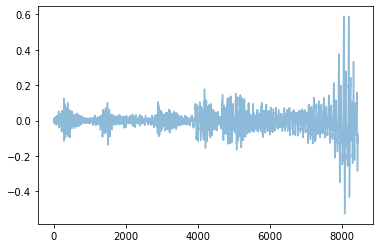

In [150]:
reconstructed_wav = vocoder.inference(batch.melspec_prediction[0:1].transpose(-1, -2)).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
# plt.grid()
# plt.legend()
plt.show()

In [151]:
display.display(display.Audio(reconstructed_wav, rate=22050))

In [110]:
reconstructed_wav = vocoder.inference(batch.melspec_prediction[0:1].transpose(-1, -2)).cpu()
waveform = vocoder.inference(batch.melspec[0:1]).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
# plt.grid()
# plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [111]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

In [75]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------
